In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import neurokit2 as nk
import scipy.signal as signal
from ipyfilechooser import FileChooser
from IPython.display import display, HTML
import ruptures as rpt
from wrangle import *
%matplotlib widget

In [13]:
required_files = [ 'synched_data.pkl.gz',
                  'event_times.pkl.gz'
                  ]
dataDirectory = "C:/home/Sessions/P009/"
print("Current directory is:", dataDirectory)
missing_files = [f for f in required_files if f not in os.listdir(dataDirectory)]
existing_files = [f for f in os.listdir(dataDirectory) if f in required_files]
if dataDirectory:
    print(f"Directory being checked: {dataDirectory}")
    if not missing_files:
        print("✓ All required files are present!")
    else:
        print("\nMissing files:")
        for file in missing_files:
            print(f"✗ {file}")
        print(f"\nFound files:")
        for file in existing_files:
            print(f"• {file}")

try:
    synched_df = pd.read_pickle(os.path.join(dataDirectory, "synched_data.pkl.gz"), compression="gzip")
    if synched_df is not None:
        print("Biosignal Data Successfully Loaded")
    else:
        print("Error loading biosignal data")
except Exception as e:
    print(f"Error loading biosignal data: {e}")

try:
    synched_raw_df = pd.read_pickle(os.path.join(dataDirectory, "synched_data_raw.pkl.gz"), compression="gzip")
    if synched_raw_df is not None:
        print("Raw Biosignal Data Successfully Loaded")
    else:
        print("Error loading raw biosignal data")
except Exception as e:
    print(f"Error loading raw biosignal data: {e}")

try:
    events_df = pd.read_pickle(os.path.join(dataDirectory, "event_times.pkl.gz"), compression="gzip")
    if events_df is not None:
        print("Test Timing Data Successfully Loaded")
    else:
        print("Error loading timing data")
except Exception as e:
    print(f"Error loading timing data: {e}")
    

display(events_df)

Current directory is: C:/home/Sessions/P009/
Directory being checked: C:/home/Sessions/P009/
✓ All required files are present!
Biosignal Data Successfully Loaded
Raw Biosignal Data Successfully Loaded
Test Timing Data Successfully Loaded


name                     start                       end
0       survey 2024-10-15 17:28:00+00:00 2024-10-15 17:31:00+00:00
1    cycle_cal 2024-10-15 17:33:00+00:00 2024-10-15 17:41:30+00:00
2   matb_train 2024-10-15 17:46:05+00:00 2024-10-15 17:58:00+00:00
3        cycle 2024-10-15 17:58:30+00:00 2024-10-15 18:03:30+00:00
4       rest_1 2024-10-15 18:04:35+00:00 2024-10-15 18:14:35+00:00
5     baseline 2024-10-15 18:17:42+00:00 2024-10-15 18:25:50+00:00
6      trial_1 2024-10-15 18:31:39+00:00 2024-10-15 18:39:40+00:00
7       rest_2 2024-10-15 18:42:50+00:00 2024-10-15 18:51:45+00:00
8      trial_2 2024-10-15 18:54:28+00:00 2024-10-15 19:02:28+00:00
9     recovery 2024-10-15 19:06:30+00:00 2024-10-15 19:21:30+00:00
10     debrief 2024-10-15 19:22:00+00:00 2024-10-15 19:25:00+00:00

## ECG Processing

ECG segment contains NaN: False
ECG segment min: -0.5759558159761992, max: 1.2480428793774287


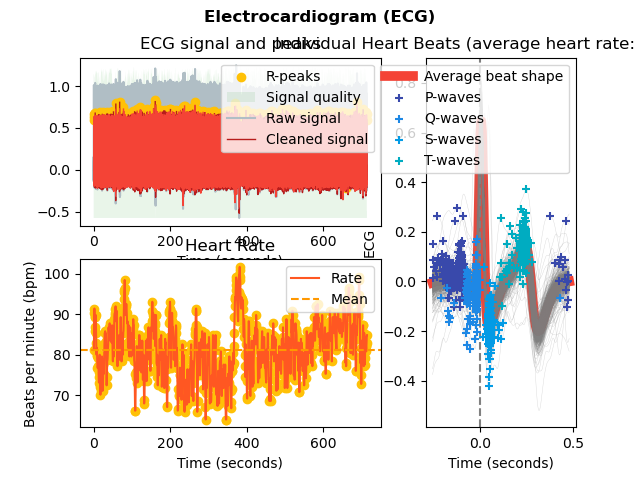

In [14]:
fs = 256
segment_name = 'matb_train'


if segment_name == 'full':
    ecg_segment = synched_df['ECG']
    start_idx = 0
    end_idx = len(synched_df['ECG'])
else:
    selected_interval = events_df[events_df['name'] == segment_name].iloc[0]
    start_time = selected_interval['start']
    end_time = selected_interval['end']

    start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
    end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)

    ecg_segment = synched_df['ECG'][start_idx:end_idx]
    
print(f"ECG segment contains NaN: {ecg_segment.isna().any()}")
print(f"ECG segment min: {ecg_segment.min()}, max: {ecg_segment.max()}")

ecg_signals, ecg_info = nk.ecg_process(
    ecg_segment, 
    sampling_rate=fs, 
    method='neurokit')

analyzed_ecg_df = nk.ecg_analyze(ecg_signals, sampling_rate=fs)


nk.ecg_plot(ecg_signals, ecg_info)

# EDA Processing

C. Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020. [journal] [pdf]


Summary Statistics:


SCR_Onsets      SCR_Peaks  SCR_RiseTime   SCR_Recovery
count      23.000000      23.000000     23.000000      20.000000
mean    82274.478261   82378.043478      0.404552   83544.600000
std     55093.187228   55090.214357      0.244189   58841.769576
min      6060.000000    6151.000000      0.242188    6197.000000
25%     34926.500000   35016.500000      0.337891   31363.250000
50%     67963.000000   68084.000000      0.355469   81263.500000
75%    116364.500000  116458.000000      0.371094  134321.750000
max    175602.000000  175713.000000      1.500000  176541.000000

SCR_Height  SCR_Amplitude   SCR_RiseTime  SCR_RecoveryTime
count  183040.000000  183040.000000  183040.000000     183038.000000
mean        0.000003       0.000004       0.000051          0.000111
std         0.000272       0.000417       0.005266          0.033081
min        -0.007477       0.000000       0.000000          0.000000
25%         0.000000       0.000000       0.000000          0.000000
50%         0.000000       0.000000       0.000000          0.000000
75%         0.000000       0.000000       0.000000          0.000000
max         0.060914       0.091224       1.500000         13.636719

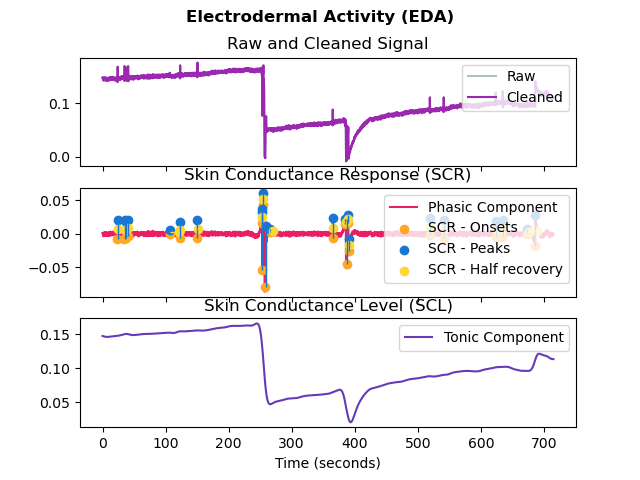

In [15]:
start_time = selected_interval['start']
end_time = selected_interval['end']

start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)
#nk.signal_plot(synched_df['EDA'].values, sampling_rate=256)
#nk.signal_plot(synched_raw_df['eda_e4'].dropna().values, sampling_rate=4)

#eda_raw_segment = synched_raw_df['eda_e4'].dropna()[0:240]
eda_segment = synched_df['EDA'][start_idx:end_idx]

#eda_segment = eda_segment * 1000

#eda_clean1 = nk.eda_clean(eda_segment, sampling_rate=256, method='neurokit')
#eda_raw_clean1 = nk.eda_clean(eda_raw_segment, sampling_rate=4, method='neurokit')

#eda_clean2 = nk.eda_clean(eda_segment, sampling_rate=256, method='biosppy')
#eda_raw_clean2 = nk.eda_clean(eda_raw_segment, sampling_rate=4, method='biosppy')

#nk.signal_plot([eda_segment, eda_clean1, eda_clean2], labels=["Raw", "NeuroKit", "BioSPPy"])

eda_signal, eda_info = nk.eda_process(eda_segment, sampling_rate=256)    # Hypothesis --- the upsampling is changing the analysis -AJS
#proc_raw_eda, proc_raw_eda_info = nk.eda_process(eda_raw_segment, sampling_rate=4)

nk.eda_plot(eda_signal, eda_info)
#nk.eda_plot(proc_raw_eda, proc_raw_eda_info)
print("\nSummary Statistics:")
eda_metrics = pd.DataFrame({
    'SCR_Onsets': eda_info['SCR_Onsets'],
    'SCR_Peaks': eda_info['SCR_Peaks'],
    'SCR_RiseTime': eda_info['SCR_RiseTime'],
    'SCR_Recovery': eda_info['SCR_Recovery']
}).describe()

display(eda_metrics)
display(eda_signal[['SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime']].describe())
#summary_stats_raw = proc_raw_eda[['SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime']].describe()

# PPG Processing

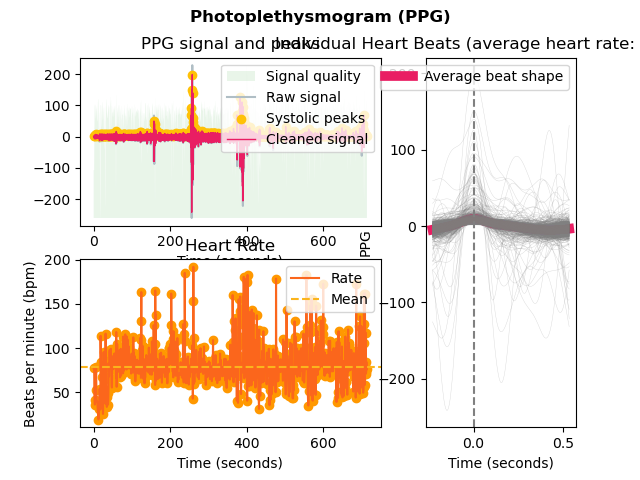

In [16]:
start_time = selected_interval['start']
end_time = selected_interval['end']

start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)

ppg_segment = synched_df['PPG'][start_idx:end_idx]

ppg_signals, ppg_info = nk.ppg_process(
    ppg_segment, 
    sampling_rate=fs, 
    method='elgendi',
    method_quality='templatematch'
)
    
analyzed_ppg_df = nk.ppg_analyze(ppg_signals, sampling_rate=fs)
    

nk.ppg_plot(ppg_signals, ppg_info)



# Respiration Processing

Filters for Cleaning:

* `khodadad2018`: Second order 0.05-3 Hz bandpass Butterworth filter.
* `BioSPPy`: Second order 0.1-0.35 Hz bandpass Butterworth filter followed by a constant detrending.
* `hampel`: Applies a median-based Hampel filter by replacing values which are 3 (can be changed via threshold) mad() away from the rolling median.

Peak Determination:
* `khodad2018`: Uses the parameters in Khodadad et al. (2018).
* `biosppy`: Uses the parameters in BioSPPy’s resp() function.
* `scipy`: Uses the scipy peak-detection function.

Respiratory Volume per Time Method:
* `power2020`
* `harrison2021`
* `birn2006`

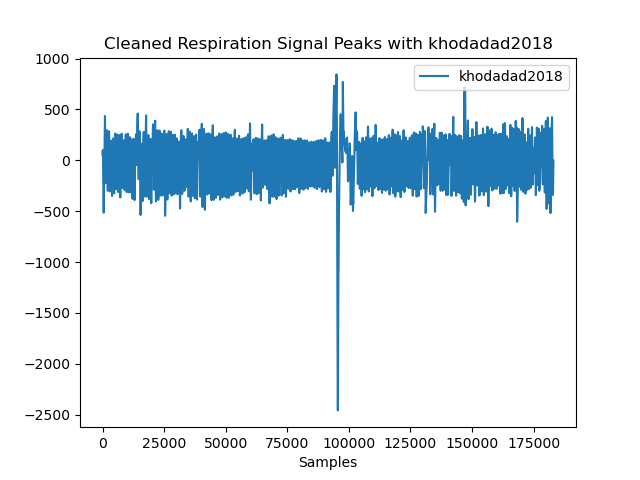

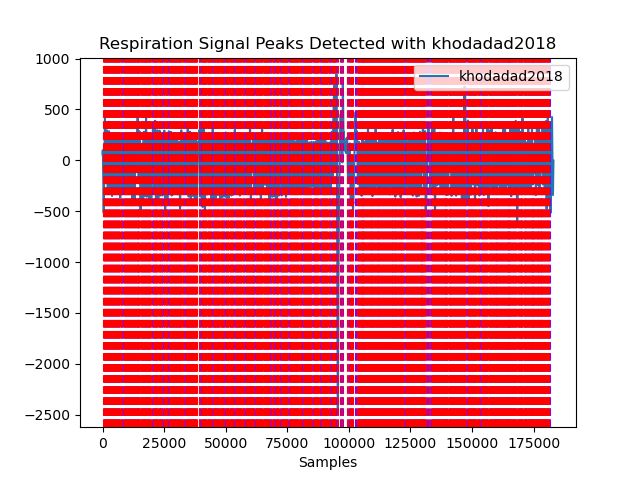

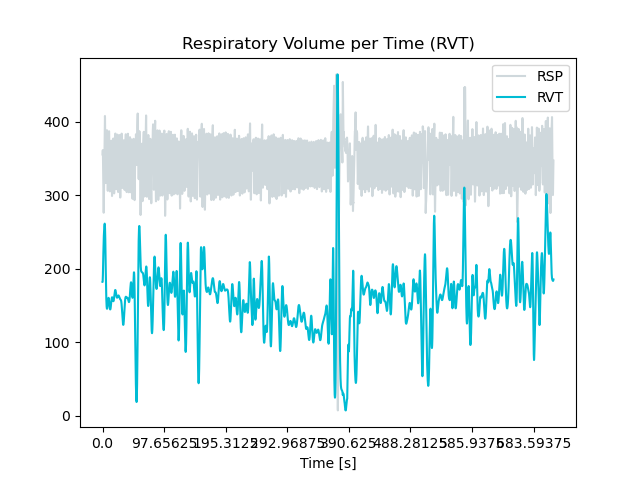

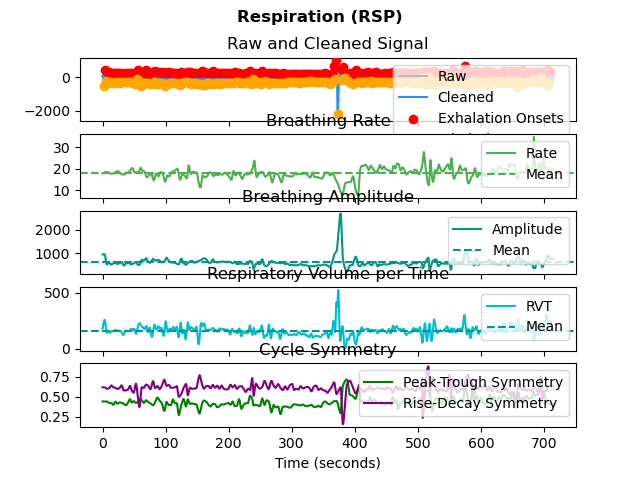

In [17]:
start_time = selected_interval['start']
end_time = selected_interval['end']

start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)

rsp_segment = synched_df['Combined Respiration'][start_idx:end_idx]
clean_methods = ['khodadad2018']
for method in clean_methods:
    rsp_cleaned = nk.rsp_clean(
        rsp_segment,
        sampling_rate=fs,
        method=method,  # 'biosppy', 'hampel', 'khodadad2018'
    )
    nk.signal_plot(rsp_cleaned, labels=[method])
    plt.title(f"Cleaned Respiration Signal Peaks with {method}")
    plt.show()

peak_methods = ['khodadad2018']
for method in peak_methods:
    rsp_peak_signal, rsp_info = nk.rsp_peaks(
            rsp_cleaned,
            sampling_rate=fs,
            method=method,   # 'khodadad2018', 'biosppy', 'scipy'
            amplitude_min=0.3,
            )
    data = pd.concat([pd.DataFrame({"RSP": rsp_cleaned}), rsp_peak_signal], axis=1)
    fig = nk.signal_plot(data, labels=[method])
    plt.title(f"Respiration Signal Peaks Detected with {method}")
    plt.show()
rsp_info["sampling_rate"] = fs


phase = nk.rsp_phase(rsp_peak_signal, desired_length=len(rsp_segment))
amplitude = nk.rsp_amplitude(rsp_cleaned, rsp_peak_signal)
rate = nk.signal_rate(rsp_info["RSP_Troughs"], sampling_rate=fs, desired_length=len(rsp_segment))
symmetry = nk.rsp_symmetry(rsp_cleaned, rsp_peak_signal)
rvt_methods = ['harrison2021']
for method in rvt_methods:
    resp_volume = nk.rsp_rvt(
            rsp_cleaned,
            method=method, # 'power2020', 'harrison2021`, `birn2006`
            sampling_rate=fs,
            silent=True,
            show=True,
        )
    
rsp_signals = pd.DataFrame(
        {
            "RSP_Raw": rsp_segment,
            "RSP_Clean": rsp_cleaned,
            "RSP_Amplitude": amplitude,
            "RSP_Rate": rate,
            "RSP_RVT": resp_volume,
        }
    )
rsp_signals = pd.concat([rsp_signals, phase, symmetry, rsp_peak_signal], axis=1)
peaks = np.where(rsp_signals["RSP_Peaks"] == 1)[0]
troughs = np.where(rsp_signals["RSP_Troughs"] == 1)[0]

rsp_signals, rsp_info = nk.rsp_process(rsp_cleaned, sampling_rate=fs, method='khodadad2018', method_rvt='harrison2021')
nk.rsp_plot(rsp_signals, rsp_info)


# HRV Metrics 

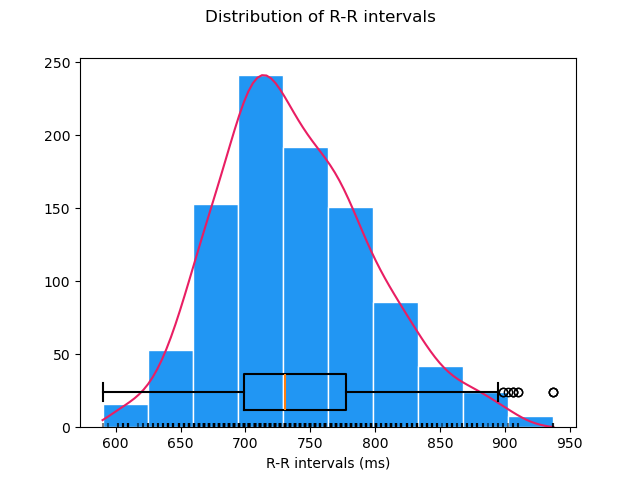

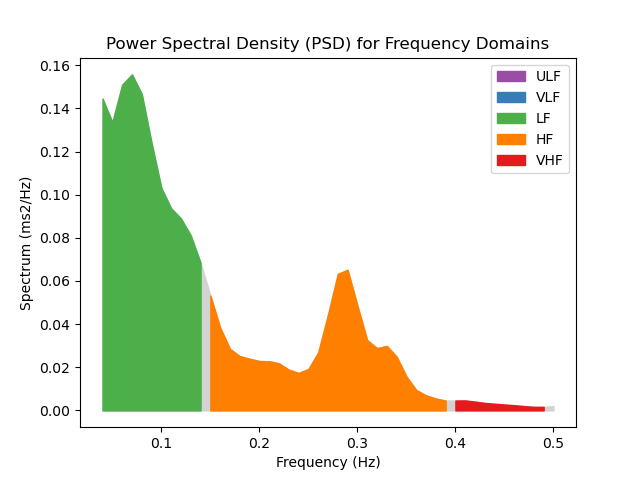

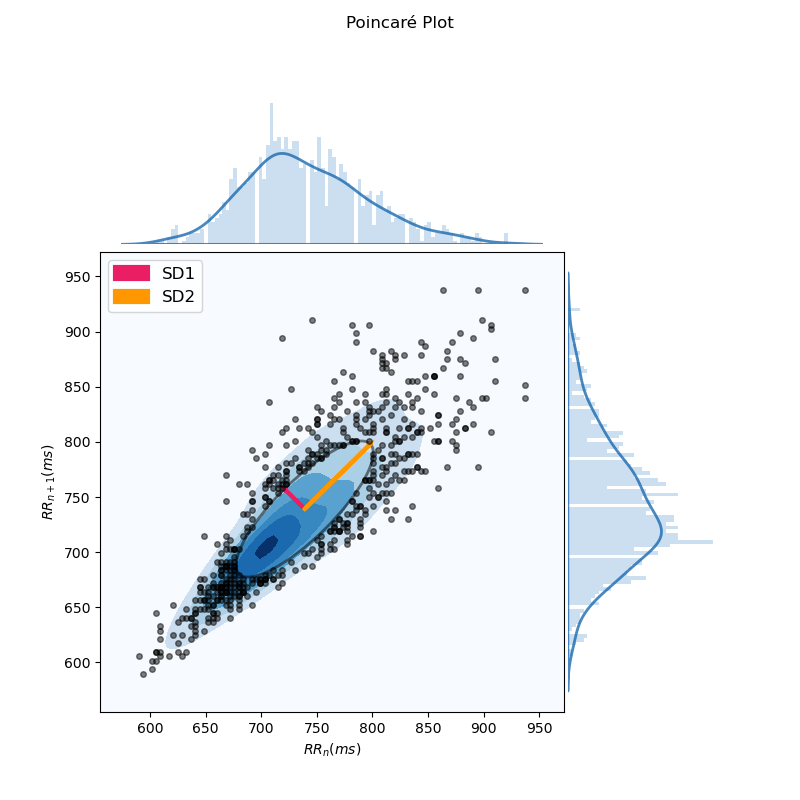

In [18]:
from hrv_methods import *
sampling_rate = fs
start_time = selected_interval['start']
end_time = selected_interval['end']

start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)

ecg_segment = synched_df['ECG'][start_idx:end_idx]

peaks = ecg_info['ECG_R_Peaks']

hrv_time_results = nk.hrv_time(peaks, sampling_rate=fs, show=True)
hrv_frequency_results = nk.hrv_frequency(peaks, sampling_rate=fs, show=True)
hrv_nonlinear_results = nk.hrv_nonlinear(peaks, sampling_rate=fs, show=True)


183040

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27408\1702083576.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hrv_extra_complexity_df = pd.concat([hrv_extra_complexity_df, hrv_extra_row], ignore_index=True)
c:\Users\Arturo\anaconda3\envs\biosig\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:582: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  739.530765  58.835436   18.103518   56.581817         NaN         NaN   
1  759.710864  70.846963   41.360816   60.061901         NaN         NaN   
2  717.593945  43.376794   20.069795   39.988061         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_CMSEn  HRV_RCMSEn  \
0         NaN         NaN  35.314093  35.364186  ...   1.454613    1.976738   
1         NaN         NaN  40.172819  40.235586  ...   1.290108    2.104029   
2         NaN         NaN  30.929447  30.977415  ...   1.371692    2.000345   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  optimal time delay  \
0  1.691763  1.700794  2.597934  0.776172                   1   
1  1.746427  1.686802  2.831189  0.726293                   1   
2  1.726231  1.747019  3.033890  0.752232                   1   

   optimal complexity dim  optimal complexity tolerance  segment duration, s  
0                       2                          0.02           238.128906  
1                       2                          0.02           243.867188  
2                       2                          0.02           230.347656  

[3 rows x 109 columns]

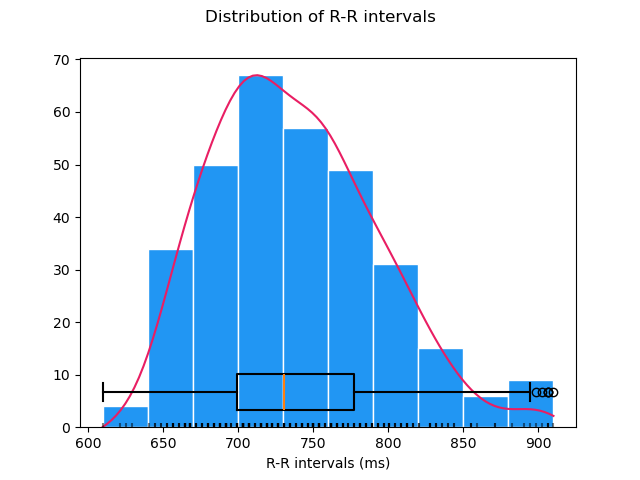

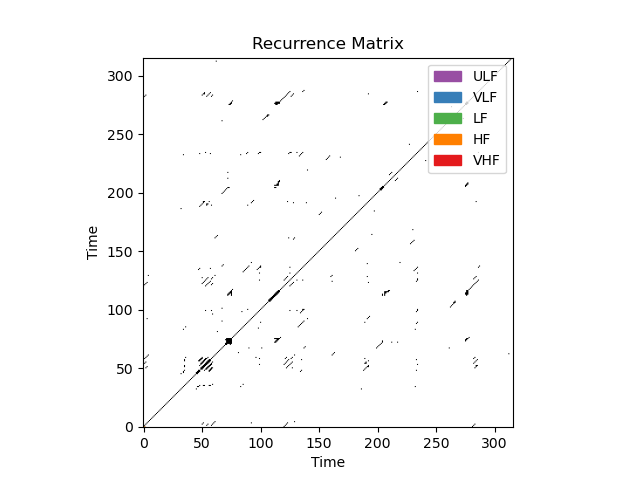

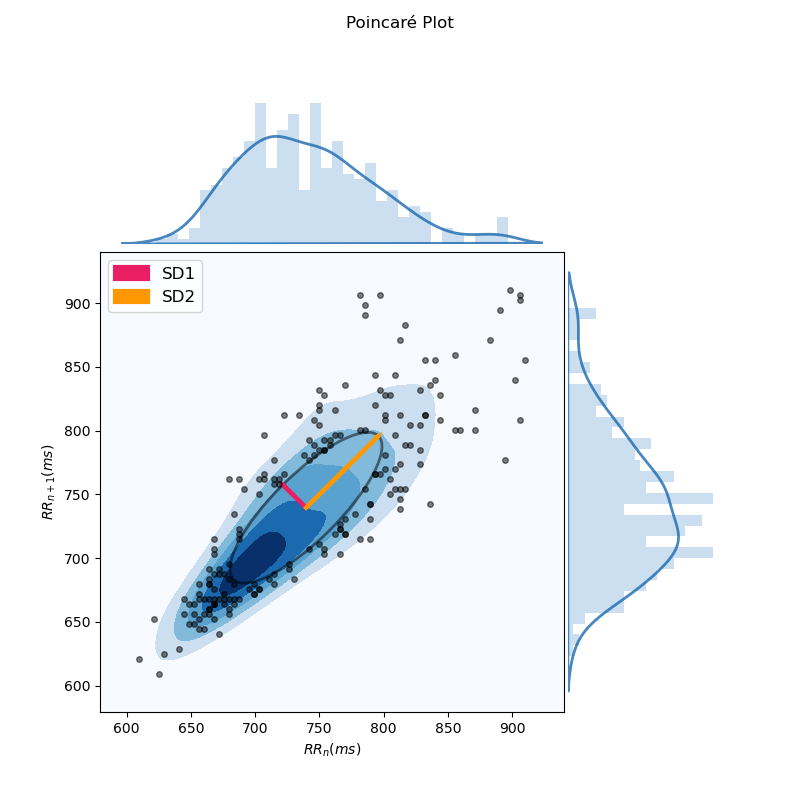

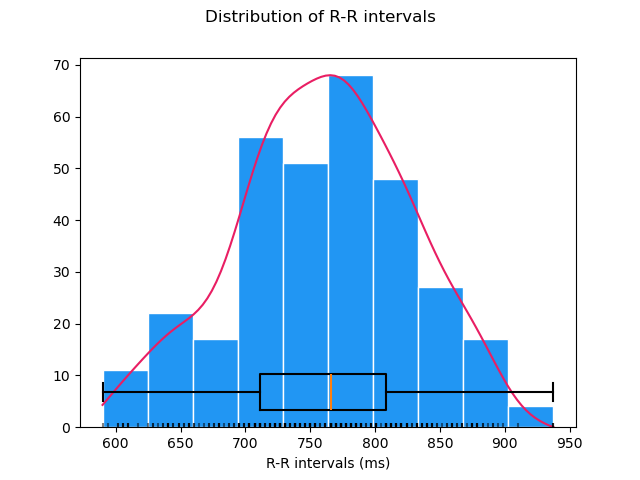

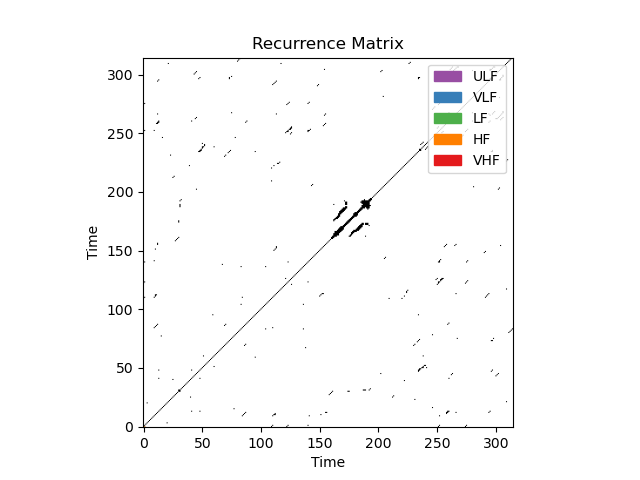

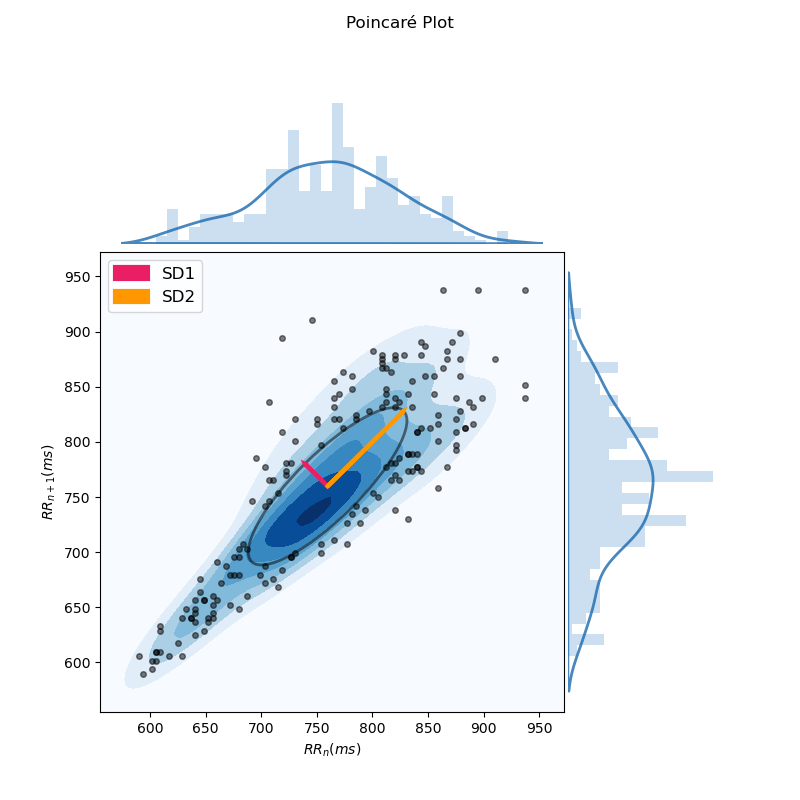

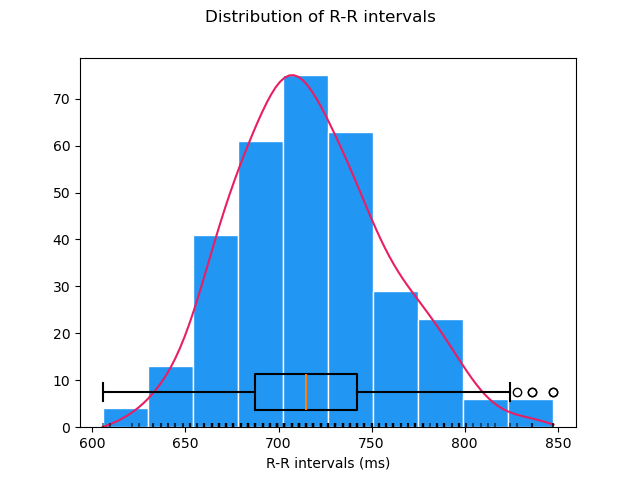

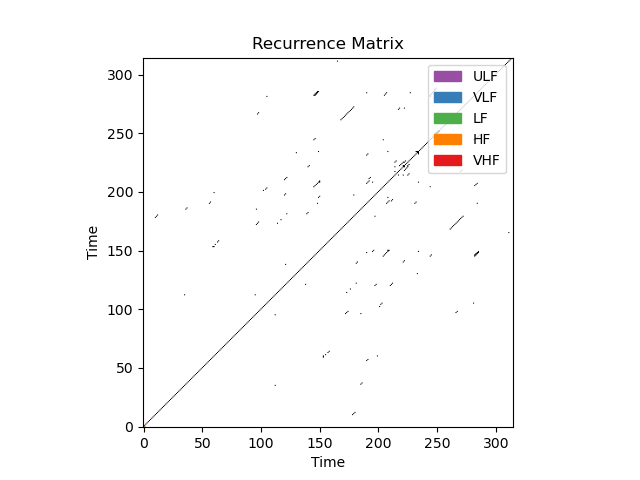

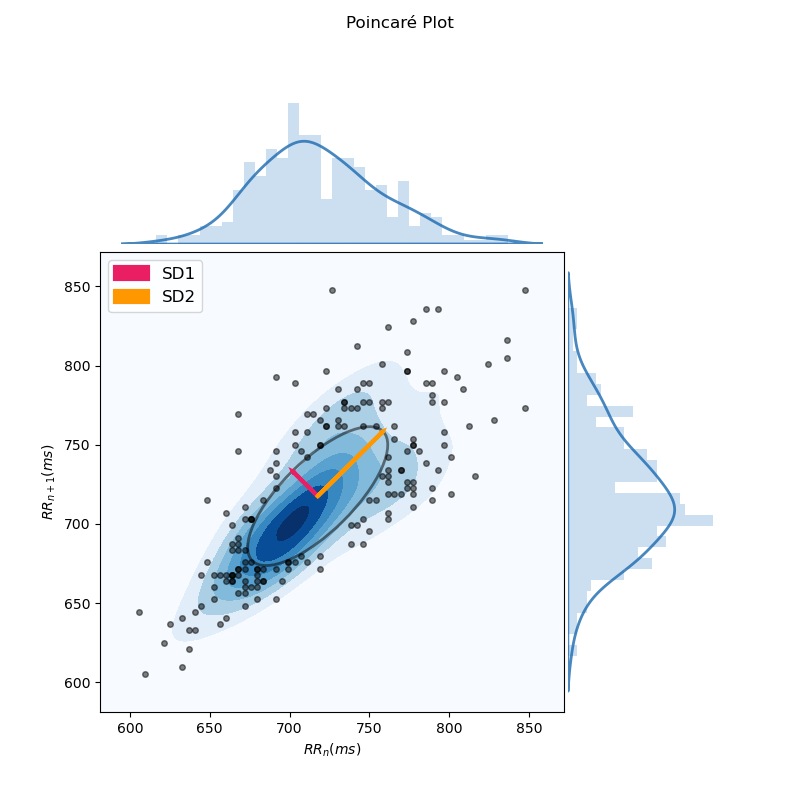

In [19]:
import warnings
warnings.filterwarnings("ignore", message=".*swapaxes.*", category=FutureWarning)

# Assuming ecg_segment is your data array and sampling_rate is 256 Hz
sampling_rate = 256

# Process the entire ECG signal to get the R-peaks


def compute_HRV(peaks, ecg_segment, sampling_rate):
    segment_length = 180 * sampling_rate  # Mess with changing segment_length here -AJS
    divider = len(ecg_segment) // segment_length 
    segments = np.array_split(peaks, divider)
    
    hrv_extra_columns = ['optimal time delay', 'optimal complexity dim', 'optimal complexity tolerance', 'segment duration, s']
    hrv_extra_complexity_df = pd.DataFrame(columns=hrv_extra_columns)

    hrv_results = []

    for i, segment in enumerate(segments):
        if len(segment) < 2:
            print(f"Segment {i} skipped due to insufficient R-peaks: {len(segment)}")
            continue
        

        hrv_time = nk.hrv_time(segment, sampling_rate=sampling_rate, show=True)
        #display(hrv_time)
        hrv_frequency = nk.hrv_frequency(segment, sampling_rate=sampling_rate, show=True)
        #display(hrv_frequency)
        hrv_rqa = nk.hrv_rqa(segment, sampling_rate=sampling_rate, show=True)
        #display(hrv_rqa)
        hrv_nonlinear = nk.hrv_nonlinear(segment, sampling_rate=sampling_rate, show=True)
        
        hrv_complexity_df, _ = nk.complexity(
            signal=segment,
            which=["makowski2022"],
            delay=1,
            dimension=2,
            tolerance="sd"
        )

        optimal_complexity_delay_value = 1
        optimal_complexity_dimension_value = 2
        optimal_complexity_tolerance_value = 0.02

        segment_duration = (segment[-1] - segment[0]) / sampling_rate

        hrv_extra_row = pd.DataFrame([{
            'optimal time delay': optimal_complexity_delay_value,
            'optimal complexity dim': optimal_complexity_dimension_value,
            'optimal complexity tolerance': optimal_complexity_tolerance_value,
            'segment duration, s': segment_duration
        }])

        if not hrv_extra_row.isna().all(axis=None):
            hrv_extra_complexity_df = pd.concat([hrv_extra_complexity_df, hrv_extra_row], ignore_index=True)


        # Combine HRV metrics for the segment
        hrv_combined = pd.concat([hrv_time, hrv_frequency, hrv_rqa, hrv_nonlinear, hrv_complexity_df], axis=1)
        hrv_combined = pd.concat([hrv_combined, hrv_extra_row.reset_index(drop=True)], axis=1)

        # Append to results
        hrv_results.append(hrv_combined)

    # Combine all segments into a single DataFrame
    if not hrv_results:
        print("No valid HRV metrics computed.")
        return pd.DataFrame()

    hrv_final_df = pd.concat(hrv_results, ignore_index=True)

    return hrv_final_df


display(len(ecg_segment))
hrv_results = compute_HRV(ecg_info['ECG_R_Peaks'], ecg_segment, sampling_rate)
display(hrv_results.head())

# Change Point Detection

In [ ]:
prominent_features = {
        #"ECG LF/HF": hrv_frequency_results["HRV_LFHF"],
        #"ECG #ibis": hrv_time_results["HRV_NN"],
        #"ECG RMSSD": hrv_time_results["HRV_RMSSD"],
        #"ECG Mean HR": hrv_time_results["HRV_MeanNN"],
        #"PPG LF/HF": ppg_hrv_frequency_results["HRV_LFHF"],
        #"PTT": ptt_results["PTT"],
        #"eda": eda_results["EDA"]
    }


KeyError: 'HRV_NN'

#### EDA CPD

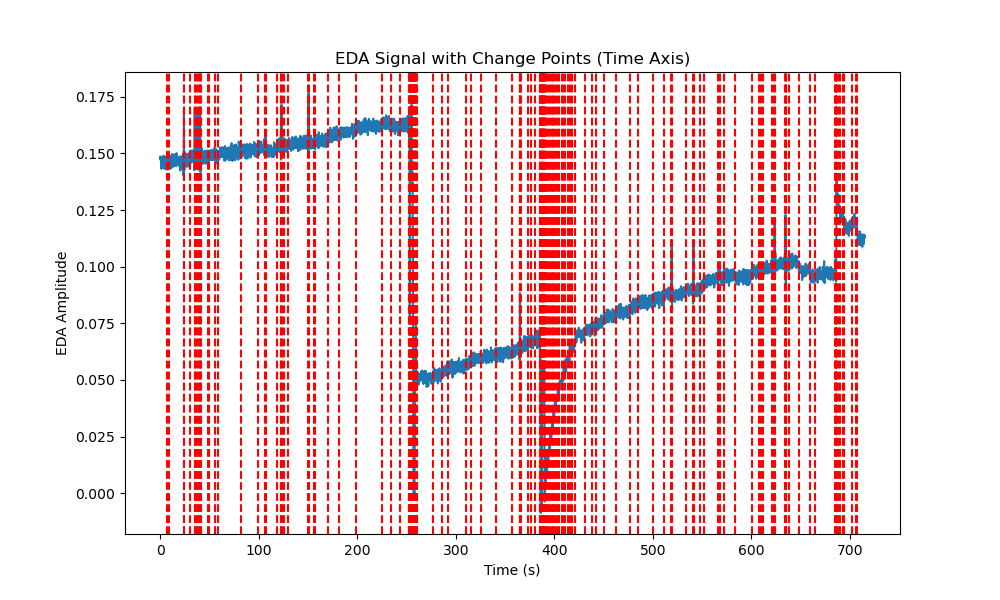

c:\Users\Arturo\anaconda3\envs\biosig\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


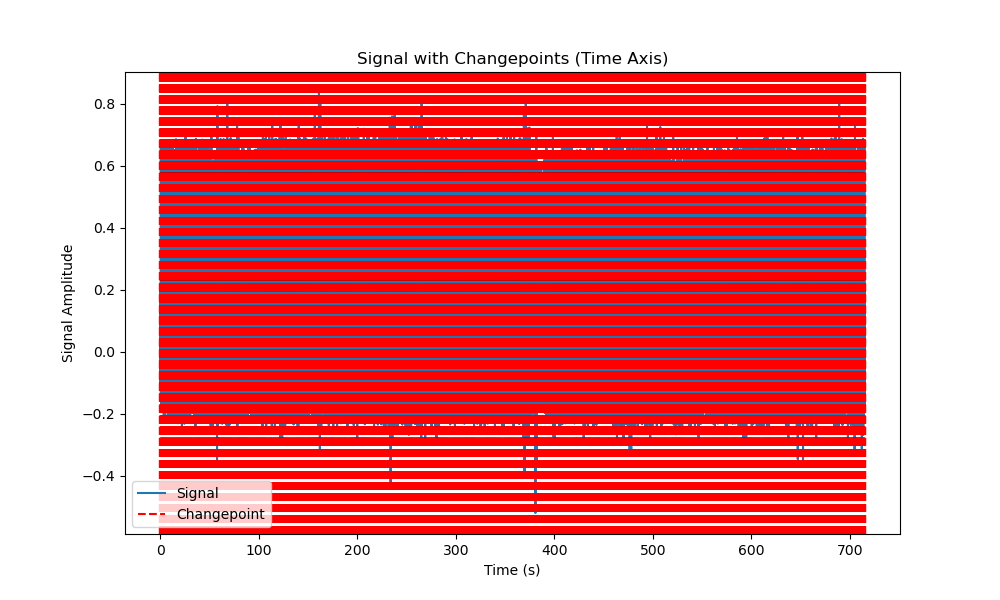

In [ ]:


eda_clean_array = eda_signal['EDA_Clean'][:].values
model = 'l2'
algo_c = rpt.KernelCPD(kernel='linear', min_size=10).fit(eda_clean_array) # minimum size in samples for a changepoint.... 

bkpts = algo_c.predict(pen=.001)

sampling_rate = 256
num_samples = len(eda_clean_array)
time = np.linspace(0, num_samples/sampling_rate, num_samples)

# Changepoint conversion, excluding the last index
bkpts_time = [time[i] for i in bkpts if i < num_samples]

# Visualization with Time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, eda_clean_array)
for bkpt in bkpts_time:
    ax.axvline(bkpt, color='red', linestyle='--')

plt.xlabel("Time (s)")
plt.ylabel("EDA Amplitude")
plt.title("EDA Signal with Change Points (Time Axis)")
plt.show()



In [ ]:

def detect_and_plot_changepoints(signal, sampling_rate, kernel='linear', min_size=10, penalty=0.001):
    """
    Detect changepoints in a signal and visualize them on a time axis.

    Parameters:
        signal (array-like): The input signal for changepoint detection.
        sampling_rate (int): Sampling rate of the signal in Hz.
        kernel (str): The kernel to use for the KernelCPD algorithm. Default is 'linear'.
        min_size (int): Minimum size (in samples) for a changepoint. Default is 10.
        penalty (float): Penalty for the changepoint algorithm. Default is 0.001.

    Returns:
        bkpts (list): Indices of detected changepoints in the signal.
        bkpts_time (list): Corresponding times (in seconds) of detected changepoints.
    """
    # Fit the changepoint detection model
    algo_c = rpt.KernelCPD(kernel=kernel, min_size=min_size).fit(signal)
    bkpts = algo_c.predict(pen=penalty)

    # Convert changepoints to time, excluding the last index
    num_samples = len(signal)
    time = np.linspace(0, num_samples / sampling_rate, num_samples)
    bkpts_time = [time[i] for i in bkpts if i < num_samples]

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time, signal, label="Signal")
    for bkpt in bkpts_time:
        ax.axvline(bkpt, color='red', linestyle='--', label="Changepoint" if bkpt == bkpts_time[0] else "")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal Amplitude")
    plt.title("Signal with Changepoints (Time Axis)")
    plt.legend(loc='upper right')
    plt.show()

    return bkpts, bkpts_time

sampling_rate = 256 
ecg_clean_array = ecg_signals['ECG_Clean'].values
bkpts, bkpts_time = detect_and_plot_changepoints(
    signal=ecg_clean_array,
    sampling_rate=sampling_rate,
    kernel='linear',
    min_size=100,
    penalty=10
)